## Machine Learning: Regression

Regression is a class of ML algorithms that predict some numeric value.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
import sklearn.compose
import sklearn.tree

As an example let's consider a dataset that predicts prices of railway tickets between European cities:

In [19]:
df = pd.read_csv("../../data/renfe-rail-sample.zip",compression='zip')
df

,Unnamed: 0,id,company,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,seats,departure_hour,geodistance
0,37402744,37402745,renfe,MADRID,BARCELONA,2020-09-28,2020-09-28,2.83,AVE,Turista,108.90,Flexible,232.0,18,506.741151
1,37402745,37402746,renfe,MADRID,BARCELONA,2020-09-28,2020-09-28,2.50,AVE,Turista Plus,115.65,Promo +,40.0,19,506.741151
2,37402746,37402747,renfe,MADRID,BARCELONA,2020-09-28,2020-09-28,3.17,AVE,Turista,108.90,Flexible,177.0,20,506.741151
3,37402747,37402748,renfe,MADRID,BARCELONA,2020-10-10,2020-10-10,3.17,AVE,Turista,108.90,Flexible,279.0,7,506.741151
4,37402748,37402749,renfe,MADRID,BARCELONA,2020-10-10,2020-10-10,3.07,AVE,Turista,108.90,Flexible,238.0,9,506.741151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246671,38753055,38753056,renfe,ZARAGOZA,BARCELONA,2020-10-08,2020-10-08,1.85,AVE,Turista Plus,54.75,Promo +,15.0,18,256.506445
1246672,38753056,38753057,renfe,ZARAGOZA,BARCELONA,2020-10-08,2020-10-08,1.80,AVE,Turista,60.90,Flexible,215.0,18,256.506445
1246673,38753057,38753058,renfe,ZARAGOZA,BARCELONA,2020-10-08,2020-10-08,2.12,ALVIA,Turista,53.60,Flexible,20.0,19,256.506445
1246674,38753058,38753059,renfe,ZARAGOZA,BARCELONA,2020-10-08,2020-10-08,1.57,AVE,Turista,60.90,Flexible,29.0,19,256.506445


Let's split the dataset between training set and test set (or validation set):

In [ ]:
df_train, df_test = sk.model_selection.train_test_split(df,train_size=0.8)

In [ ]:
len(df_train),len(df_test)

To begin with, let's predict the price using only one parameter - distance between cities. Let's visualize it:

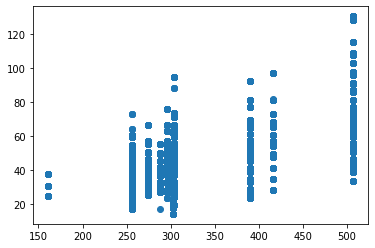

In [8]:
X = df_train["geodistance"]
Y = df_train["price"]
plt.scatter(X,Y)
plt.show()

### Linear Regression 

Linear regression is a simplest model, in which predictive function is linear: $f_{a,b}(x) = ax+b$. Here $a$ and $b$ are model parameters, which we need to find in order to train the model.

We can take **mean square error** as a measure of how well our model performs. In this case, **model loss** will be given by

$$
L(a,b) = {1\over n}\sum_i (f_{a,b}(x_i)-y_i)^2 ={1\over n} \sum_i (ax_i+b-y_i)^2
$$

To find the minimum, let's make a derivative equal to 0:

$$
\begin{cases}
{\partial L\over\partial b} = \sum_i 2(ax_i+b-y_i) = 0 \cr
{\partial L\over\partial a} = \sum_i 2(ax_i+b-y_i)x_i = 0
\end{cases}
$$

From the equations above:
$$
\begin{cases}
a\sum x_i + nb  = \sum y_i \\
a\sum x_i^2 + b\sum x_i = \sum x_iy_i
\end{cases}
$$

Solving this with respect to $a$ and $b$, we get:
$$
\begin{cases}
a = {\sum x_i\sum y_i - n\sum x_iy_i \over (\sum x_i)^2 - n\sum x_i^2} \\
b = {\sum y_i\sum x_i^2 - \sum x_i\sum x_iy_i \over \sum x_i^2(n - \sum x_i) }
\end{cases}
$$

This approach to analytic solution is called **method of least squares**.

In [9]:
n = len(X)
a = (X.sum()*Y.sum()-n*(X*Y).sum())/(X.sum()*X.sum()-n*(X*X).sum())
b = (Y.sum()*(X*X).sum()-X.sum()*(X*Y).sum())/(X*X).sum()/(n-X.sum())
print(f"a={a}, b={b}")

a=0.15113189045373288, b=-0.0006913013700446183


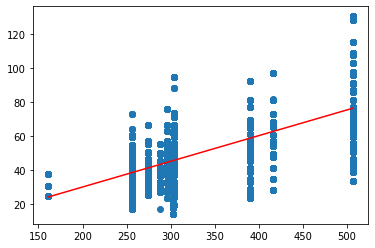

In [10]:
plt.scatter(X,Y)
lX = [X.min(),X.max()]
lY = [a*x+b for x in lX]
plt.plot(lX,lY,c='red')
plt.show()

Let's compute the error on our test set:

In [11]:
X_t, Y_t = df_test["geodistance"], df_test["price"]

def MSE(x,y):
    return np.mean(np.square(x-y)) 

def MAE(x,y):
    return np.mean(np.abs(x-y))

print(f"MSE={np.sqrt(MSE(a*X_t+b,Y_t))}, MAE={MAE(a*X_t+b,Y_t)}, MAE(%)={MAE(a*X_t+b,Y_t)/Y_t.mean()}")

MSE=16.31640695770404, MAE=13.626511621993185, MAE(%)=0.28508426595099234


We can now predict the price with an error of 28%.

### Gradient Descent Optimization

Least squares can be used for any number of input variables. However, for large number it becomes too computationally challenging, thus another technique is used to find approximate solution, called **gradient descent optimization**.

It goes as follows: first, we set parameters to some random initial values $a_0, b_0$. Then, at each step of optimization, we compute loss on the dataset (either on the whole dataset, or on some subset of it which is called **minibatch** - in this case optimization is called **stochastic gradient descent**, SGD), and then adjust weights in the following manner:
$$\begin{cases}
a^{(i+1)} = a^{(i)} - \eta{\partial L\over\partial a} \\
b^{(i+1)} = b^{(i)} - \eta{\partial L\over\partial b} \\
\end{cases}$$

Here $\eta$ is some relatively small value called **learning rate**.

Using mean squared error (MSE) as loss:
$$
MSE = {1\over n}\sum_i(aX_i+b-Y_i)^2
$$
we can manually compute the derivatives:
$$\begin{cases}
{\partial L\over\partial a} = {2\over n} \sum_i (aX_i+b-Y_i)*X_i \\
{\partial L\over\partial b} = {2\over n} \sum_i (aX_i+b-Y_i)
\end{cases}$$

In [18]:
a,b = np.random.normal(size=2)
eta = 0.000005
for i in range(100):
    print(f"Epoch {i}: MSE={MSE(a*X+b,Y)}")
    # print(f"a={a},b={b}")
    a,b = a-eta*((a*X+b-Y)*X).mean(), b-eta*(a*X+b-Y).mean()

Epoch 0: MSE=362854.9087240552
Epoch 1: MSE=89132.19483813443
Epoch 2: MSE=22044.66003990515
Epoch 3: MSE=5601.971519045763
Epoch 4: MSE=1571.9828385077815
Epoch 5: MSE=584.2606204918517
Epoch 6: MSE=342.1767686428096
Epoch 7: MSE=282.8436981477278
Epoch 8: MSE=268.3015740459077
Epoch 9: MSE=264.73739960472227
Epoch 10: MSE=263.8638443285806
Epoch 11: MSE=263.6497411116202
Epoch 12: MSE=263.59726500917054
Epoch 13: MSE=263.58440259215996
Epoch 14: MSE=263.5812492114576
Epoch 15: MSE=263.58047544758347
Epoch 16: MSE=263.58028491369373
Epoch 17: MSE=263.58023732504694
Epoch 18: MSE=263.5802247699034
Epoch 19: MSE=263.5802208025903
Epoch 20: MSE=263.5802189374
Epoch 21: MSE=263.5802175908461
Epoch 22: MSE=263.58021636816807
Epoch 23: MSE=263.5802151783403
Epoch 24: MSE=263.58021399583293
Epoch 25: MSE=263.5802128153165
Epoch 26: MSE=263.5802116339748
Epoch 27: MSE=263.5802104546923
Epoch 28: MSE=263.58020927516316
Epoch 29: MSE=263.580208094595
Epoch 30: MSE=263.580206914077
Epoch 31: MSE

Let's see the result:

MSE=273.9208182663147, MAE=13.745276936857437, MAE(%)=0.2875689901084111


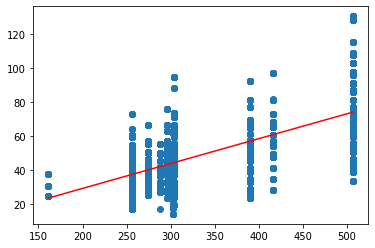

In [17]:
print(f"MSE={MSE(a*X_t+b,Y_t)}, MAE={MAE(a*X_t+b,Y_t)}, MAE(%)={MAE(a*X_t+b,Y_t)/Y_t.mean()}")
plt.scatter(X,Y)
lX = [X.min(),X.max()]
lY = [a*x+b for x in lX]
plt.plot(lX,lY,c='red')
plt.show()

As we can see, the result is almost the same as in the least squares method. 

> **IMPORTANT**: Success of the method largely depends on the selection of $\eta$ parameter. Try to increase or decrease $\eta$ by an order of magnitude and see what happens.

### Adding Features

Let's add some more numeric features:

In [34]:
X = df_train[["geodistance","duration","departure_hour"]]
X_t = df_test[["geodistance","duration","departure_hour"]]

*a, b = np.random.normal(size=4)
a = np.array(a)
eta = 0.000005
for i in range(25):
    print(f"Epoch {i}: MSE={MSE(X@a+b,Y)}")
    # print(f"a={a},b={b}")
    a,b = a-eta*((X@a+b-Y)*X.T).mean(axis=1), b-eta*(X@a+b-Y).mean()

Epoch 0: MSE=283366.14048107475
Epoch 1: MSE=69446.400755393
Epoch 2: MSE=17189.69310029394
Epoch 3: MSE=4424.324775243086
Epoch 4: MSE=1305.972606508179
Epoch 5: MSE=544.2110813457602
Epoch 6: MSE=358.1218037338035
Epoch 7: MSE=312.65879072163875
Epoch 8: MSE=301.5482188140307
Epoch 9: MSE=298.8293252330903
Epoch 10: MSE=298.1603676577213
Epoch 11: MSE=297.9921737457993
Epoch 12: MSE=297.94630886107933
Epoch 13: MSE=297.9303283022937
Epoch 14: MSE=297.9216495087689
Epoch 15: MSE=297.9147559713255
Epoch 16: MSE=297.9083001061367
Epoch 17: MSE=297.90195272198724
Epoch 18: MSE=297.8956334038444
Epoch 19: MSE=297.8893225064206
Epoch 20: MSE=297.88301522959165
Epoch 21: MSE=297.87671040132915
Epoch 22: MSE=297.8704077337817
Epoch 23: MSE=297.86410715651317
Epoch 24: MSE=297.8578086509984


In [35]:
a,b

(geodistance       0.157880
 duration          1.305873
 departure_hour   -0.206895
 dtype: float64,
 -0.9276304720080177)

In [36]:
print(f"MSE={MSE(X_t@a+b,Y_t)}, MAE={MAE(X_t@a+b,Y_t)}, MAE(%)={MAE(X_t@a+b,Y_t)/Y_t.mean()}")

MSE=296.6336740697011, MAE=14.531191944288345, MAE(%)=0.3040113496211487


### Categorical Features

Most probably, such features as **class** or **fare** play an important role in the price prediction.

In [37]:
df["fare"].value_counts()

Promo +       566980
Flexible      422474
Adulto ida    257222
Name: fare, dtype: int64

Let's plot the average price depending on the fare:

<AxesSubplot:xlabel='fare'>

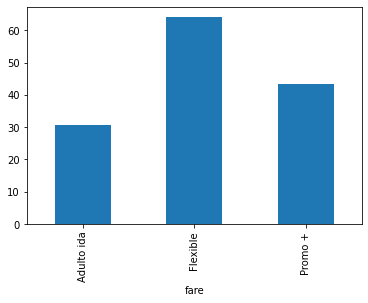

In [38]:
df.groupby('fare').mean()['price'].plot(kind='bar')

Categorical features can be of two types:

* **Nominal**, when feature values are just distinct values with no specific order. For example, color, or city name
* **Ordinal**, when feature value somehow reflect the magnitude of the underlying concept. For example, grades (A, B, F-, etc.), or attitude indicators (Very negative/negative/neutral/positive/very positive).

Depending on the feature type, we can use different encoding techniques:
* **Label Encoding**, where each value is encoded by some numeric value. This approach is good for **ordinal** features. For example, we can replace grades by a number from 0 to 7. This should not be used for nominal features, because it introduces additional relation into the data, which is not originally there.
* **One-Hot Encoding** is better suited for **nominal** features, where for each feature value we introduce separate column containing 0 and 1. In other words, we encode feature value by a 0-1 vector, where 1 is placed the position according to the feature value, eg. red color can be represented by (1,0,0,0,0,0,0), and green - by (0,0,0,1,0,0,0).
* There are also other encoding technique described [in this blog post](https://habr.com/ru/post/666234/)

In our case, it is not completely obvious which approach to use. Taking into account the chart above, fares can probably be places in this order of increasing price: Adulto, Promo+, Flexible - and thus can be encoded by numbers 0, 1 and 2 respectively.

Or, we can use one-hot encoding and make no assumptions on relative prices of different fares. In `pandas` we can use `get_dummies` function to make one-hot encoding:

In [39]:
pd.get_dummies(df["fare"])

,Adulto ida,Flexible,Promo +
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
1246671,0,0,1
1246672,0,1,0
1246673,0,1,0
1246674,0,1,0


In [51]:
X = pd.get_dummies(df_train,columns=["fare"])[['geodistance','fare_Adulto ida','fare_Promo +','fare_Flexible']]
X_t = pd.get_dummies(df_test,columns=["fare"])[['geodistance','fare_Adulto ida','fare_Promo +','fare_Flexible']]
X

,geodistance,fare_Adulto ida,fare_Promo +,fare_Flexible
643182,415.639080,0,0,1
24226,274.364753,0,0,1
296779,274.364753,0,0,1
337154,296.103026,0,1,0
574647,415.639080,0,0,1
...,...,...,...,...
604285,303.573264,0,1,0
716261,161.318295,1,0,0
210916,506.741151,0,0,1
833523,303.573264,0,1,0


In [58]:
mx = np.max(X['geodistance'])
X['geodistance'] = X['geodistance']/mx
X_t['geodistance'] = X_t['geodistance']/mx

In [59]:
X

,geodistance,fare_Adulto ida,fare_Promo +,fare_Flexible
643182,0.820220,0,0,1
24226,0.541430,0,0,1
296779,0.541430,0,0,1
337154,0.584328,0,1,0
574647,0.820220,0,0,1
...,...,...,...,...
604285,0.599070,0,1,0
716261,0.318345,1,0,0
210916,1.000000,0,0,1
833523,0.599070,0,1,0


In [67]:
*a, b = np.random.normal(size=5)
a = np.array(a)
eta = 1
for i in range(50):
    print(f"Epoch {i}: MSE={MSE(X@a+b,Y)}")
    # print(f"a={a},b={b}")
    a,b = a-eta*((X@a+b-Y)*X.T).mean(axis=1), b-eta*(X@a+b-Y).mean()

Epoch 0: MSE=2865.228187476198
Epoch 1: MSE=1657.943576714217
Epoch 2: MSE=1005.7046474485037
Epoch 3: MSE=650.454614722423
Epoch 4: MSE=455.30333080293985
Epoch 5: MSE=346.9416508200866
Epoch 6: MSE=285.8406609732678
Epoch 7: MSE=250.58141764419256
Epoch 8: MSE=229.5167826245248
Epoch 9: MSE=216.29641978275296
Epoch 10: MSE=207.450369469677
Epoch 11: MSE=201.0785812931586
Epoch 12: MSE=196.1380769651537
Epoch 13: MSE=192.05437840956657
Epoch 14: MSE=188.50938048958986
Epoch 15: MSE=185.32542500076298
Epoch 16: MSE=182.40189848148566
Epoch 17: MSE=179.68053480918752
Epoch 18: MSE=177.12641615789423
Epoch 19: MSE=174.7175635470015
Epoch 20: MSE=172.43922915430176
Epoch 21: MSE=170.2807630942043
Epoch 22: MSE=168.23389030398238
Epoch 23: MSE=166.2917600535703
Epoch 24: MSE=164.44841898052937
Epoch 25: MSE=162.69851645608176
Epoch 26: MSE=161.0371375252301
Epoch 27: MSE=159.45970604169332
Epoch 28: MSE=157.96192652866057
Epoch 29: MSE=156.53974751977637
Epoch 30: MSE=155.18933691446713
Ep

In [68]:
print(f"MSE={MSE(X_t@a+b,Y_t)}, MAE={MAE(X_t@a+b,Y_t)}, MAE(%)={MAE(X_t@a+b,Y_t)/Y_t.mean()}")

MSE=138.60939525702906, MAE=9.064085511887162, MAE(%)=0.18963240456220326


We can see that by using additional columns we can significantly improve the accuracy of our model. This is because those additional features contain important information about the ticket which we now take into account.

In linear regression, we can look at the coefficients of the model corresponding to different features, which makes our model **interpretable**:

In [69]:
a

geodistance        61.413384
fare_Adulto ida    -5.150950
fare_Promo +       -4.885373
fare_Flexible      19.410887
dtype: float64

## Scikit Learn

Instead of programming gradient descent by hand, we can use an existing library to apply regression algorithm to our data. De facto standard in Machine Learning is a library called [Scikit Learn](https://scikit-learn.org/stable/index.html). 

Let's implement linear regression using Scikit Learn. To begin with, let's list all numerical and categorical features:

In [70]:
numeric = ['geodistance','duration','departure_hour']
categorical = ['vehicle_type','vehicle_class','fare']

To train our regression only on numerical features, we can use this simple code:

In [71]:
X = df_train[numeric]
model = sk.linear_model.LinearRegression()
model = model.fit(X,Y)

The main method to train the model is called `fit`. It is because finding the best parameters to minimize loss is called *fitting the model*.

Let's compute error on test data:

In [72]:
X_t = df_test[numeric]
Y_t_pred = model.predict(X_t)
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Y_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Y_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Y_t_pred)}")

MSE=224.12337472414933, MAE=11.956206383677657, MAE(%)=0.28853313390431107


Let's look at the model's coefficients:

In [73]:
print(f"Coefficients={model.coef_}, bias={model.intercept_}")

Coefficients=[ 0.17548784 -3.97626639  0.19966081], bias=2.095870133440812


To encode categorical features, we can also use Scikit Learn mechanisms. Objects to do the encoding are called **Encoders**. That's how we can use encoders:

In [74]:
ohe = sk.preprocessing.OneHotEncoder()
ohe.fit(df[["fare","vehicle_class"]])
print(ohe.categories_)
ohe.transform(df[["fare","vehicle_class"]]).toarray()[:10]

[array(['Adulto ida', 'Flexible', 'Promo +'], dtype=object), array(['Turista', 'Turista Plus', 'Turista con enlace'], dtype=object)]


array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.]])

To apply different encoders to different colums, we can use another abstraction called **transformer**. We can obtain the encoded table in one go, specifying encoders for all categorical features, and making all other columns pass through unchanged:

In [77]:
transformer = sk.compose.make_column_transformer(
    (sk.preprocessing.OneHotEncoder(),['fare']),
    (sk.preprocessing.OneHotEncoder(),['vehicle_type']),
    (sk.preprocessing.OneHotEncoder(),['vehicle_class']),
    (sk.preprocessing.StandardScaler(),['geodistance']),
    (sk.preprocessing.StandardScaler(),['duration']),
    (sk.preprocessing.StandardScaler(),['departure_hour']),
    remainder='passthrough'
)
X = transformer.fit_transform(df_train[numeric+categorical])
X.toarray()[:2]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.14515559,  0.08587623,  0.58423994],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        , -0.27656092, -0.61756428, -1.40937142]])

Obtained values can be used to train the model:

In [78]:
model = sk.linear_model.LinearRegression()
model = model.fit(X,Y)
X_t = transformer.transform(df_test[numeric+categorical])
Y_t_pred = model.predict(X_t)
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Y_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Y_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Y_t_pred)}")

MSE=75.3224979242507, MAE=6.046722009473211, MAE(%)=0.14033664217945888


### Adding Attributes

Sometimes, the result are not a linear function of features. For example, when computing the remaining amount of money on a bank account which follows compound interest are likely to follow exponential relationship from time. In this case we can improve the quality of the model by replacing the value by a logarithm.

In the same manner, we can try to improve the accuracy of a linear model by adding to the original dataset some functions of features or their combinations, which become new features for an extended linear model. 

One of the approaches to do it automatically is to add **polynomial combinations** of features. For example, if original dataset contain features $x_1, x_2, x_3$, then adding all second-order polynomial features we get $x_1^2, x_2^2, x_3^2, x_1x_2, x_1x_3, x_2x_3$, in addition to original features.

This can also be done using a transformer:

In [79]:
poly = sk.preprocessing.PolynomialFeatures()
Xp = poly.fit_transform(X)
X.shape,Xp.shape

((997340, 24), (997340, 325))

From 24 features we obtained 325 features! Now let's train the model:

In [80]:
model.fit(Xp,Y)

Xp_t = poly.transform(X_t)
Yp_t_pred = model.predict(Xp_t)
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Yp_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Yp_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Yp_t_pred)}")

MSE=50.35765535651989, MAE=4.631631254581291, MAE(%)=0.1098326687935525


### Using Pipelines

In our example we have used `ColumnTransformer` to encode non-numeric features, then `PolynomialFeatures` to add additional features, and then fed the result into `LinearRegression` object to train the model.

We can bundle those steps into a single **pipeline**, because all steps of this pipeline follow similar interface of having `fit` or `fit_transform` methods:

In [81]:
pipe = sk.pipeline.Pipeline([
    ('ColumnTransform',transformer),
    ('PolyFeatures',poly),
    ('LinearModel',model)
])
pipe.fit(df_train[numeric+categorical],Y)
pipe.score(df_test[numeric+categorical],Y_t)

0.8967705430902998

In [82]:
Yp_t_pred = pipe.predict(df_test[numeric+categorical])
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Yp_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Yp_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Yp_t_pred)}")

MSE=50.35765535651989, MAE=4.631631254581291, MAE(%)=0.1098326687935525


Using just a few lines of code we have built a data processing pipeline that pre-processes the data, computed additional features, trains the model and checks it for accuracy.

### Decision Trees

In our case, prices for tickets can change non-linearly, because each fare can have it's own price principles and rules. For such cases, we can use another ML algorithm - **decision trees**. A decision tree looks at some feature, and depending on its value considers several possible ways to compute the result. Then, at each of the sub-trees, we select next feature to look at, and so on.

Let's train the decision tree on our data:

In [83]:
model = sk.tree.DecisionTreeRegressor()
model = model.fit(X,Y)

Y_t_pred = model.predict(X_t)
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Y_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Y_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Y_t_pred)}")

MSE=33.65830882325588, MAE=2.85343618020788, MAE(%)=0.07116475636099631


Interestingly enough, decision trees give us fantastic accuracy! This is mostly due to the fact that we have just a few combinations of cities in our dataset, and the tree is likely to *remember* typical prices for tickts between those cities in different fares.

Trees are also interpretable, however, it gets hardly interpretable when it grows too big. For clarity, let's limit the depth of the tree - this will decrease accuracy, but will make the tree more observable:

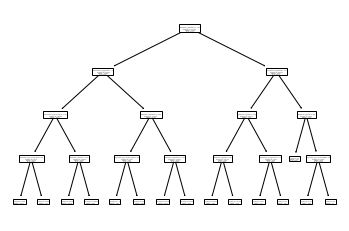

In [84]:
model = sk.tree.DecisionTreeRegressor(max_depth=4)
model = model.fit(X,Y)

z = sk.tree.plot_tree(model,feature_names=transformer.get_feature_names_out())

To get better visualization, we can use **GraphViz** library. It should be installed using `conda install python-graphviz` into your Python environment.

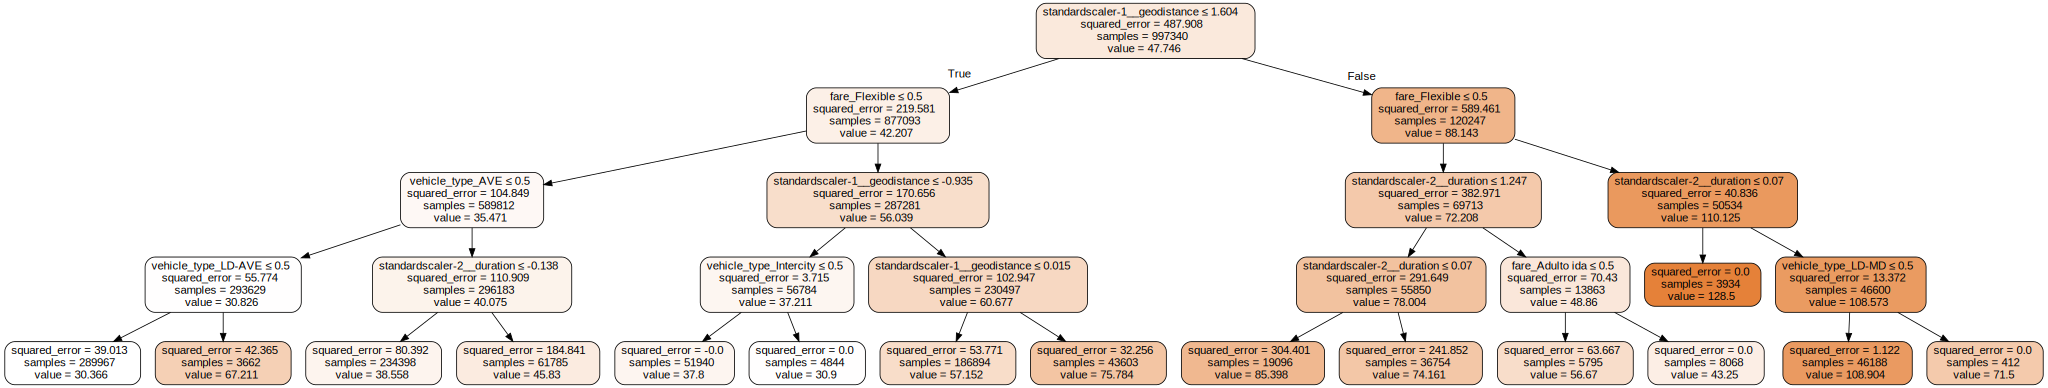

In [85]:
import graphviz
graphviz.backend.dot_command.DOT_BINARY = 'c:/winapp/conda/Library/bin/graphviz/dot.exe'

def proc_feature_name(x):
    return x.replace('onehotencoder-1__','')\
        .replace('onehotencoder-2__','')\
        .replace('onehotencoder-3__','')\
        .replace('remainder__','')

feature_names = [proc_feature_name(x) for x in transformer.get_feature_names_out()]

graphviz.Source(
    sk.tree.export_graphviz(model,feature_names=feature_names,
    filled=True, rounded=True, special_characters=True)
)